In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
csv = '/home/olga/data_sm/kmer-hashing/orthologues/human-vs-mouse/protein_coding_peptide_orthology_nsubset10000_seed0.csv'
%time df = pd.read_csv(csv)

CPU times: user 12min 55s, sys: 1min 57s, total: 14min 52s
Wall time: 14min 53s


In [4]:
parquet = csv.replace('.csv', '.parquet')

%time df.to_parquet(parquet)

CPU times: user 5min 57s, sys: 1min 40s, total: 7min 38s
Wall time: 7min 32s


## Human vs chimp

In [5]:
%%time

csv = '/home/olga/data_sm/kmer-hashing/orthologues/human-vs-chimp/protein_coding_orthology_nsubset1000_seed0.csv'

%time df = pd.read_csv(csv)

parquet = csv.replace('.csv', '.parquet')
%time df.to_parquet(parquet)

CPU times: user 27.8 s, sys: 10.8 s, total: 38.6 s
Wall time: 38.9 s
CPU times: user 3.73 s, sys: 504 ms, total: 4.23 s
Wall time: 4.23 s
CPU times: user 31.6 s, sys: 11.3 s, total: 42.8 s
Wall time: 43.2 s


## Human vs mouse lemur

In [7]:
species1 = 'human'
species2 = 'mouse lemur'

output_folder = f'/home/olga/data_sm/kmer-hashing/orthologues/{species1}-vs-{species2.replace(" ", "_")}'
print(output_folder)
! mkdir -p $output_folder
! ls -lha $output_folder

/home/olga/data_sm/kmer-hashing/orthologues/human-vs-mouse_lemur
total 7.8G
drwxrwxr-x 2 olga olga 4.0K Oct 17 01:53 .
drwxrwxr-x 8 olga olga 4.0K Nov 11 11:39 ..
-rw-rw-r-- 1 olga olga  377 Oct 19 12:52 n_homology_types.csv
lrwxrwxrwx 1 olga olga  119 Oct 17 01:53 protein_coding_orthology_nsubset1000_seed0.csv -> /home/olga/data_sm/kmer-hashing/orthologues/human-vs-mouse_lemur/protein_coding_peptide_orthology_nsubset1000_seed0.csv
-rw-rw-r-- 1 olga olga 6.5G Sep 22 23:49 protein_coding_peptide_orthology_nsubset1000_seed0.csv
-rw-rw-r-- 1 olga olga 1.4G Sep 21 00:58 protein_coding_peptide_orthology_nsubset200_seed0.csv


In [8]:
%%time

csv = '/home/olga/data_sm/kmer-hashing/orthologues/human-vs-mouse_lemur/protein_coding_peptide_orthology_nsubset1000_seed0.csv'

%time df = pd.read_csv(csv)

parquet = csv.replace('.csv', '.parquet')
%time df.to_parquet(parquet)

CPU times: user 1min 53s, sys: 12.2 s, total: 2min 5s
Wall time: 2min 6s
CPU times: user 32.9 s, sys: 4.34 s, total: 37.2 s
Wall time: 38 s
CPU times: user 2min 26s, sys: 16.6 s, total: 2min 43s
Wall time: 2min 44s


## Human vs drosophila

In [19]:
%%time

csv = '/home/olga/data_sm/kmer-hashing/orthologues/human-vs-fly/protein_coding_peptide_orthology_nsubset1000_seed0.csv'

%time df = pd.read_csv(csv)

parquet = csv.replace('.csv', '.parquet')
%time df.to_parquet(parquet)

CPU times: user 9.16 s, sys: 484 ms, total: 9.64 s
Wall time: 9.65 s
CPU times: user 3.8 s, sys: 312 ms, total: 4.11 s
Wall time: 4.14 s
CPU times: user 13 s, sys: 804 ms, total: 13.8 s
Wall time: 13.8 s


## Experiment with getting mean differences between samples

In [20]:
i = 0

def get_median_diff(x):
    medians = x.groupby('is_homologue')['jaccard'].median()
    return medians.diff().iloc[-1]

def get_mean_diff(x):
    means = x.groupby('is_homologue')['jaccard'].mean()
    return means.diff().iloc[-1]

def get_std_diff(x):
    stds = x.groupby('is_homologue')['jaccard'].std()
    return stds.diff().iloc[-1]

for (molecule, ksize), x in df.groupby(['molecule', 'ksize']):
    means = x.groupby('is_homologue')['jaccard'].mean()
    medians = x.groupby('is_homologue')['jaccard'].median()
    
    i += 1
    if i > 1:
        break

In [28]:
median_df = df.groupby(['molecule', 'ksize']).apply(get_median_diff).reset_index()
median_df = median_df.rename(columns={0: "diff_medians"})
print(median_df.shape)
median_df.head()

(195, 3)


,molecule,ksize,diff_medians
0,botvinnik,2,0.001572
1,botvinnik,3,0.016978
2,botvinnik,4,0.050645
3,botvinnik,5,0.034755
4,botvinnik,6,0.018127


In [29]:
mean_df = df.groupby(['molecule', 'ksize']).apply(get_mean_diff).reset_index()
mean_df = mean_df.rename(columns={0: "diff_means"})

print(mean_df.shape)
mean_df.head()

(195, 3)


,molecule,ksize,diff_means
0,botvinnik,2,-0.001790
1,botvinnik,3,0.015573
2,botvinnik,4,0.060747
3,botvinnik,5,0.061027
4,botvinnik,6,0.048211


In [30]:
diff_df = mean_df.merge(median_df, on=['molecule', 'ksize'])
diff_df.head()

,molecule,ksize,diff_means,diff_medians
0,botvinnik,2,-0.001790,0.001572
1,botvinnik,3,0.015573,0.016978
2,botvinnik,4,0.060747,0.050645
3,botvinnik,5,0.061027,0.034755
4,botvinnik,6,0.048211,0.018127


In [38]:
molecules = 'protein', 'dayhoff', 'hydrophobic-polar'
diff_df = diff_df.query('molecule in @molecules')

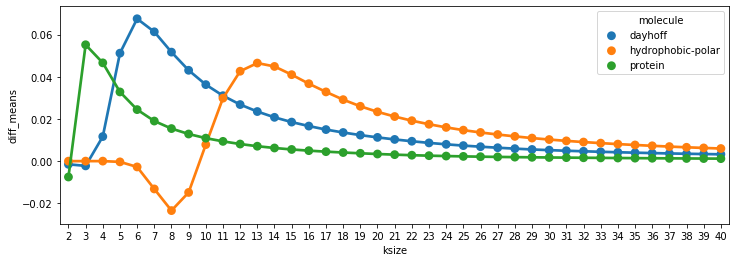

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.pointplot(x='ksize', y='diff_means', hue='molecule', 
              data=diff_df)

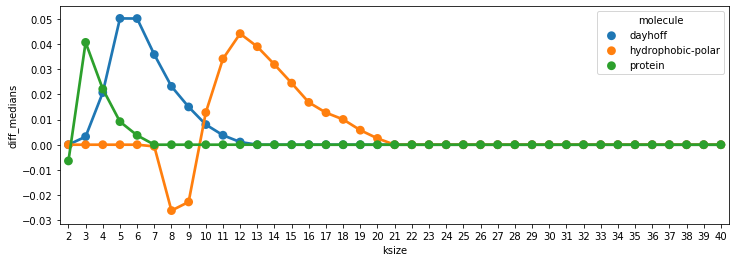

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.pointplot(x='ksize', y='diff_medians', hue='molecule', data=diff_df)

In [21]:
noncoding_rows = orthologs['Query protein or transcript ID'].str.startswith("ENST")
noncoding_rows.sum()

34

In [19]:
homology_table.protein_coding = homology_table.data.loc[~noncoding_rows]
homology_table.protein_coding.shape

(167446, 21)

In [20]:
homology_table.non_coding = homology_table.data.loc[noncoding_rows]
homology_table.non_coding.shape

(34, 21)

In [21]:
df.groupby(['molecule', 'ksize']).apply(get_std_diff)

molecule   ksize
botvinnik  2       -0.003848
           3       -0.004595
           4        0.034724
           5        0.077336
           6        0.084366
                      ...   
protein    36       0.023136
           37       0.022700
           38       0.022265
           39       0.021830
           40       0.021395
Length: 195, dtype: float64

In [23]:
means

is_homologue
No homology    0.530834
True           0.546407
Name: jaccard, dtype: float64

In [24]:
means.diff()

is_homologue
No homology         NaN
True           0.015573
Name: jaccard, dtype: float64

In [14]:
means.diff().iloc[-1]

0.3871176397234848

In [12]:
medians

is_homologue
No homology    0.483051
True           0.909804
Name: jaccard, dtype: float64

In [15]:
medians.diff().iloc[-1]

0.42675307411100033